In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from ergochemics.mapping import get_reaction_center
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
import numpy as np
import polars as pl
from src.post_processing import PathWrangler
from pathlib import Path

def get_lhs_block_rc(am_smarts: str) -> list[int]:
    return get_reaction_center(am_smarts, mode="combined")[0]

In [2]:
study = "test" # test

In [3]:
krs = pl.read_parquet("/home/stef/bottle/artifacts/known/known_reactions.parquet")
krs.head()

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""e908a824c912d1e39c46de92d1f738…","""**.NC(CCC(=O)NC(CS)C(=O)NCC(=O…","[""P10649"", ""P50472"", … ""Q08863""]","""3bbe8e6dca0da1c745e7678c8efebe…","[""RHEA:16438""]"
"""d86d99a8143d3be8fc861a5de5e625…","""*.*.*.*.*.*.*.*.*.*.CC(C)(COP(…","[""A0A0C6E0I7"", ""A0A0C6DWS6"", … ""Q0UK50""]","""e99fb0b75e799eba72aee21c1d04ee…","[""RHEA:51350""]"
"""2972b2db66715ba6f3d6aeaf07f31b…","""*.*.*.*.*.*.*.*.*NC(COP(=O)(O)…","[""G0REX6"", ""A0A482N9V7"", ""P0DO30""]","""5a7fffef224c65b7cd431ddc668eb2…","[""RHEA:64546""]"
"""572e4a84a946af07c9ab6fd1c0347b…","""*.*.*.*.*.*.*.*.*OP(=O)(O)OCC(…","[""A5UNX8"", ""Q57952"", … ""Q9V2B0""]","""c4c936d8d985a457a128601b8d2769…","[""RHEA:64377""]"
"""dfe7fc761de3c213bf2b18fae4f8a5…","""*.*.*.*.*.*.*.*.CC(C)CCCC(C)CC…","[""A5UNX8"", ""Q57952"", … ""Q9V2B0""]","""2e026380a550baa6b343604e6f5500…","[""RHEA:64369""]"


In [5]:
prs = pl.read_parquet(
    f"/home/stef/quest_data/bottle/data/processed/{study}/predicted_reactions.parquet"
)
prs.head()

id,smarts,am_smarts,dxgb_label,rxn_sims,analogue_ids,rules
str,str,str,i32,list[f32],list[str],list[str]
"""9f253320d7bca474613904857fe220…","""CC(C)(C=O)CO.O.O=O>>CC(C)(CO)C…","""[CH3:1][C:2]([CH3:3])([CH:6]=[…",1,[0.636364],"[""a82e81a8b3785c0cdf6c054b25b14561ed41411b""]","[""mechinferred_dt_04:5319""]"
"""ce317f2c07f1475ff6ea9b2a123f28…","""CC(C)(CO)C(=O)C(=O)O>>CC(C)(C=…","""[CH3:1][C:2]([CH3:3])([CH2:6][…",1,[0.596285],"[""7067f7e39db265cc16d06488905549d0b8f8d548""]","[""mechinferred_dt_04:2541""]"


In [7]:
paths = pl.read_parquet(
    f"/home/stef/quest_data/bottle/data/processed/{study}/paths.parquet"
)
paths.head()

path_id,rxn_id,main_pdt_id,rxn_type,generation
str,str,str,enum,i32
"""6170a1fe9a05969e8643959462b26e…","""9f253320d7bca474613904857fe220…","""6569ea8ebe9fdd8627adb76f7d942d…","""predicted""",0
"""6170a1fe9a05969e8643959462b26e…","""ce317f2c07f1475ff6ea9b2a123f28…","""ec6099fb494f7feb318cdb6f5fda4e…","""predicted""",1


In [9]:
path_stats = pl.read_parquet(
    f"/home/stef/quest_data/bottle/data/processed/{study}/path_stats.parquet"
)
path_stats.head()

id,starters,targets,dg_opt,dg_err,starter_ids,target_ids,mdf,mean_max_rxn_sim,mean_mean_rxn_sim,min_max_rxn_sim,min_mean_rxn_sim,feasibility_frac
str,list[str],list[str],list[f32],list[f32],list[str],list[str],f32,f32,f32,f32,f32,f32
"""6170a1fe9a05969e8643959462b26e…","[""08a914cde05039694ef0194d9ee79ff9a79dde33"", ""1aa818910461f5961959eb05dd06b8f7a4fbbb9f"", ""107689e3f574227f080ebd294ba5a5812ee482b8""]","[""6569ea8ebe9fdd8627adb76f7d942dbbbb83c56d""]",null,null,"[""08a914cde05039694ef0194d9ee79ff9a79dde33"", ""1aa818910461f5961959eb05dd06b8f7a4fbbb9f"", ""107689e3f574227f080ebd294ba5a5812ee482b8""]","[""6569ea8ebe9fdd8627adb76f7d942dbbbb83c56d""]",null,0.616324,0.616324,0.596285,0.596285,1.0
"""6170a1fe9a05969e8643959462b26e…","[""08a914cde05039694ef0194d9ee79ff9a79dde33"", ""1aa818910461f5961959eb05dd06b8f7a4fbbb9f"", ""107689e3f574227f080ebd294ba5a5812ee482b8""]","[""6569ea8ebe9fdd8627adb76f7d942dbbbb83c56d""]",null,null,"[""08a914cde05039694ef0194d9ee79ff9a79dde33"", ""1aa818910461f5961959eb05dd06b8f7a4fbbb9f"", ""107689e3f574227f080ebd294ba5a5812ee482b8""]","[""6569ea8ebe9fdd8627adb76f7d942dbbbb83c56d""]",null,0.616324,0.616324,0.596285,0.596285,1.0


In [20]:
pw = PathWrangler(study=Path(f"/home/stef/quest_data/bottle/data/processed/{study}"), known=Path('/home/stef/bottle/artifacts/known'))

In [25]:
pw.starters, pw.targets

(('107689e3f574227f080ebd294ba5a5812ee482b8',
  '1aa818910461f5961959eb05dd06b8f7a4fbbb9f',
  '08a914cde05039694ef0194d9ee79ff9a79dde33'),
 ('6569ea8ebe9fdd8627adb76f7d942dbbbb83c56d',))

In [31]:
pw.get_paths(
    starters=pw.starters,
    targets=pw.targets,
    sort_by="min_mean_rxn_sim",
    filter_by_enzymes={'existence': ["Evidence at protein level", "Evidence at transcript level", "Inferred from homology"]},
)

{'paths': shape: (4, 17)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ id        ┆ starters  ┆ targets   ┆ dg_opt    ┆ … ┆ rxn_id    ┆ main_pdt_ ┆ rxn_type  ┆ generati │
 │ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ id        ┆ ---       ┆ on       │
 │ str       ┆ list[str] ┆ list[str] ┆ list[f32] ┆   ┆ str       ┆ ---       ┆ enum      ┆ ---      │
 │           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆           ┆ i32      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ 6170a1fe9 ┆ ["08a914c ┆ ["6569ea8 ┆ null      ┆ … ┆ 9f253320d ┆ 6569ea8eb ┆ predicted ┆ 0        │
 │ a05969e86 ┆ de0503969 ┆ ebe9fdd86 ┆           ┆   ┆ 7bca47461 ┆ e9fdd8627 ┆           ┆          │
 │ 43959462b ┆ 4ef0194d9 ┆ 27adb76f7 ┆           ┆   ┆ 3904857fe ┆ adb76f7d9 ┆           ┆          │
 │ 26e…      ┆ ee7…      ┆ d94…      ┆           ┆   ┆ 22

Reaction 1: Rd4dbba9b573905855d9da01cf31985af9e9ba0f9cbb8ac22af3dcf4b94dc529c


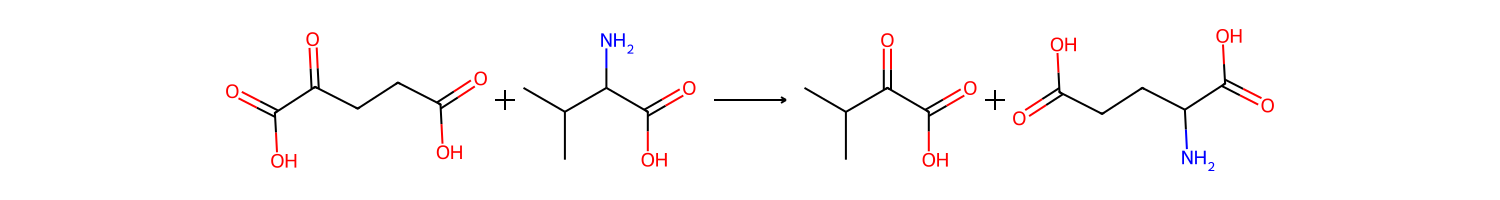

Reaction 2: R2ba791552723ca9705a8d138d33ef478fe8feb5d0405f8f2414d9f29027819ef


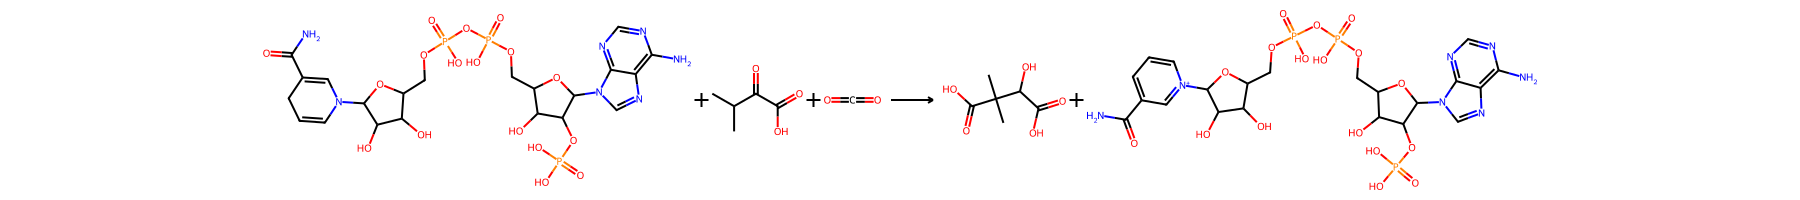

Reaction 3: Rb76a86d1614b6bd328c96ea23e083cfcbcae06ff791e30c7036ddab697e7fbd4


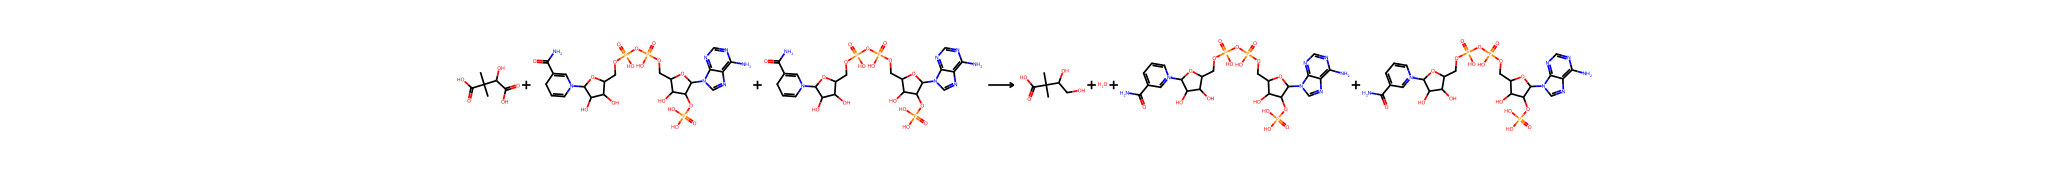

Reaction 4: R3258aef59dfd631844d137779f54c4c2bcbde79355c73cb6a3ab9de43a87707d


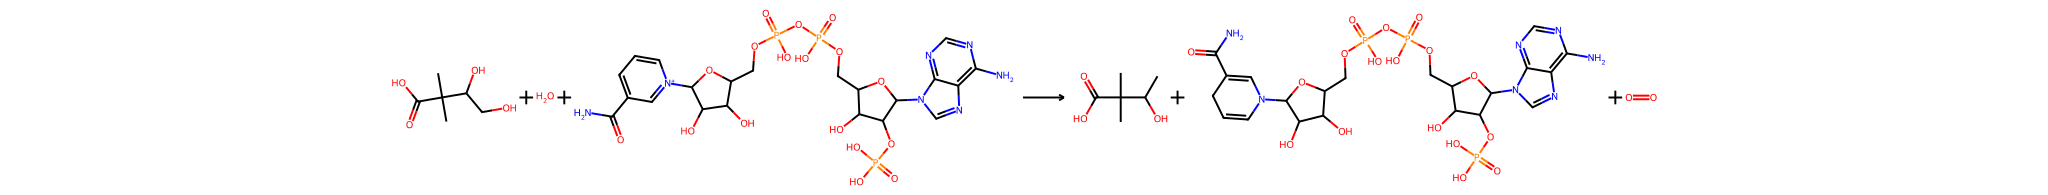

In [10]:
pid = 'Pf89188'
rids = paths.filter(pl.col("id").str.starts_with(pid))["reactions"].to_list()[0]
path = prs.filter(pl.col("id").is_in(rids)).sort(
    pl.col("id").replace({id: idx for idx, id in enumerate(rids)})
).select(pl.col("smarts"), pl.col("id"))
for i, row in enumerate(path.iter_rows(named=True)):
    print(f"Reaction {i+1}: {row['id']}")
    display(
        SVG(
            draw_reaction(row['smarts'])
        )
    )

In [11]:
prs.filter(
    pl.col("id") == 'R2ba791552723ca9705a8d138d33ef478fe8feb5d0405f8f2414d9f29027819ef'
)

id,smarts,am_smarts,dxgb_label,rxn_sims,analogue_ids,rules
str,str,str,i32,list[f32],list[str],list[str]
"""R2ba791552723ca9705a8d138d33ef…","""NC(=O)C1=CN(C2OC(COP(=O)(O)OP(…","""[NH2:1][C:2](=[O:3])[C:4]1=[CH…",0,[1.0],"[""a3f4476043106c928cf3733d68f33cd7cd092206""]","[""mechinferred_dt_13_rules:2698""]"


In [12]:
krs.filter(
    pl.col("id") == "a3f4476043106c928cf3733d68f33cd7cd092206"
)

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""a3f4476043106c928cf3733d68f33c…","""CC(C)C(=O)C(=O)O.NC(=O)C1=CN(C…",[],"""c85a8e015e2783295784987102b3d7…","[""RHEA:13323""]"


In [6]:
prs = pl.scan_parquet(
    f"/home/stef/quest_data/bottle/results/{study}/predicted_reactions.parquet"
).filter(
    pl.col("id").is_in(
        [
            "R911b2dd7b4dd9a29f0bd7d84ca8e57ea7e77bbad67a8f07bd2697813e3c75628",
            "R83707e0a53210a8928c08edb9a934e8a6bcc7970c17c627f2d29d4ae5b208b55"
        ]
    )
).collect()
prs.head()

id,smarts,am_smarts,dxgb_label,rxn_sims,analogue_ids,rules,reversed
str,str,str,i32,list[f32],list[str],list[str],bool
"""R83707e0a53210a8928c08edb9a934…","""CC(O)C(C)CC(=O)O>>CC(O)C(C)(C)…","""[CH3:1][CH:2]([OH:3])[CH:4]([C…",0,[0.5],"[""12848""]","[""mechinferred_dt_98_rules:2003""]",null
"""R911b2dd7b4dd9a29f0bd7d84ca8e5…","""CCC(C)C(O)C(=O)O>>CC(O)C(C)CC(…","""[CH3:7][CH2:6][CH:4]([CH3:5])[…",0,"[0.485071, 0.411765]","[""15268"", ""16573""]","[""mechinferred_dt_98_rules:1100""]",null


Reaction 1: R83707e0a53210a8928c08edb9a934e8a6bcc7970c17c627f2d29d4ae5b208b55


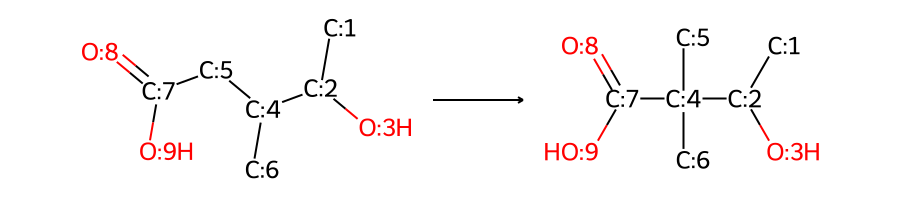

Reaction 2: R911b2dd7b4dd9a29f0bd7d84ca8e57ea7e77bbad67a8f07bd2697813e3c75628


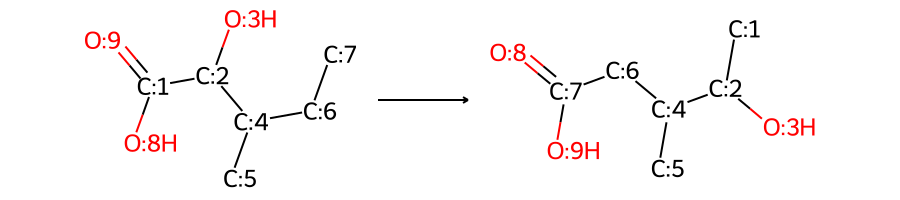

In [7]:
for i, row in enumerate(prs.iter_rows(named=True)):
    print(f"Reaction {i+1}: {row['id']}")
    display(
        SVG(
            draw_reaction(row['am_smarts'])
        )
    )

In [8]:
from ergochemics.mapping import operator_map_reaction

In [9]:
rxn = row["smarts"]
rule = "([#6:1].[#8:2]=[#6:3]-[#8:4])>>([#6:3].[#8:4]=[#6:1]-[#8:2])"
res = operator_map_reaction(rxn, rule)
res

[08:43:14] Initializing MetalDisconnector
[08:43:14] Running MetalDisconnector
[08:43:14] Initializing Normalizer
[08:43:14] Running Normalizer
[08:43:14] Initializing MetalDisconnector
[08:43:14] Running MetalDisconnector
[08:43:14] Initializing Normalizer
[08:43:14] Running Normalizer


OperatorMapResult(did_map=True, aligned_smarts='CCC(C)C(O)C(=O)O>>CC(O)C(C)CC(=O)O', atom_mapped_smarts='[CH3:3][CH2:5][CH:6]([CH3:7])[CH:8]([OH:9])[C:1](=[O:4])[OH:2]>>[CH3:1][CH:8]([OH:9])[CH:6]([CH3:7])[CH2:5][C:3](=[O:2])[OH:4]', reaction_center=(((0, 7, 6, 8),), ((0, 6, 7, 8),)))

In [10]:
mechinferred_98 = pl.read_csv(
    "/home/stef/bottle/artifacts/rules/mechinferred_dt_98_rules_w_coreactants.tsv",
    separator="\t",
)

rule_smarts = mechinferred_98.filter(
    pl.col("Name") == "1100_0"
)["SMARTS"][0]

In [11]:
rule_smarts

'([C&D1&v4&H3&0*&!R&z0:1].[C&D3&v4&H0&0*&!R&z2:2](=[O&D1&v2&H0&0*&!R:3])-[O&D1&v2&H1&0*&!R:4])>>([C&D1&v4&H3&0*&!R&z0:2].[C&D3&v4&H0&0*&!R&z2:1](=[O&D1&v2&H0&0*&!R:4])-[O&D1&v2&H1&0*&!R:3])'

In [12]:
Chem.MolFromSmarts(rule_smarts.split(">>")[0])

[08:43:14] SMARTS Parse Error: syntax error while parsing: ([C&D1&v4&H3&0*&!R&z0:1].[C&D3&v4&H0&0*&!R&z2:2](=[O&D1&v2&H0&0*&!R:3])-[O&D1&v2&H1&0*&!R:4])
[08:43:14] SMARTS Parse Error: Failed parsing SMARTS '([C&D1&v4&H3&0*&!R&z0:1].[C&D3&v4&H0&0*&!R&z2:2](=[O&D1&v2&H0&0*&!R:3])-[O&D1&v2&H1&0*&!R:4])' for input: '([C&D1&v4&H3&0*&!R&z0:1].[C&D3&v4&H0&0*&!R&z2:2](=[O&D1&v2&H0&0*&!R:3])-[O&D1&v2&H1&0*&!R:4])'


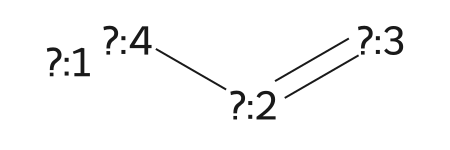

In [13]:
Chem.MolFromSmarts('[C&D1&v4&H3&0*&!R&z0:1].[C&D3&v4&H0&0*&!R&z2:2](=[O&D1&v2&H0&0*&!R:3])-[O&D1&v2&H1&0*&!R:4]')

In [14]:

rule_smarts

'([C&D1&v4&H3&0*&!R&z0:1].[C&D3&v4&H0&0*&!R&z2:2](=[O&D1&v2&H0&0*&!R:3])-[O&D1&v2&H1&0*&!R:4])>>([C&D1&v4&H3&0*&!R&z0:2].[C&D3&v4&H0&0*&!R&z2:1](=[O&D1&v2&H0&0*&!R:4])-[O&D1&v2&H1&0*&!R:3])'

In [15]:
mappings = pl.read_parquet(
    "/home/stef/bottle/artifacts/rxn_x_rule_mapping/sprhea_v3_ns_x_rc_plus_0_rules.parquet"
)
mutases = mappings.filter(
    pl.col("rxn_id").is_in(prs['analogue_ids'].explode().to_list())
)
mutases.head()

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""12848""","""CC(C)CC(=O)SCCNC(=O)CCNC(=O)C(…","""[CH3:4][CH:2]([CH3:5])[CH2:1][…","""([#6:1].[#6:2]-[#6:3])>>([#6:2…","""1,3,4>>0,1,4""",181
"""15268""","""CCC(C(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:3][CH2:5][CH:6]([C:1](=[O…","""([#6:1].[#8:2]=[#6:3]-[#8:4])>…","""0,4,3,5>>0,3,4,5""",13
"""16573""","""CC(CC(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:3][CH:5]([CH2:6][C:1](=[O…","""([#6:1].[#8:2]=[#6:3]-[#8:4])>…","""0,4,3,5>>0,3,4,5""",13


In [16]:
for i, row in enumerate(mutases.iter_rows(named=True)):
    print(row['rule'])

([#6:1].[#6:2]-[#6:3])>>([#6:2].[#6:1]-[#6:3])
([#6:1].[#8:2]=[#6:3]-[#8:4])>>([#6:3].[#8:4]=[#6:1]-[#8:2])
([#6:1].[#8:2]=[#6:3]-[#8:4])>>([#6:3].[#8:4]=[#6:1]-[#8:2])


In [17]:
mappings = pl.read_parquet(
    "/home/stef/bottle/artifacts/rxn_x_rule_mapping/sprhea_v3_ns_x_rc_plus_0_rules.parquet"
)
isom = mappings.filter(
    pl.col("rule_id") == 13
)
print(len(isom))


2


In [27]:
isom

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""15268""","""CCC(C(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:3][CH2:5][CH:6]([C:1](=[O…","""([#6:1].[#8:2]=[#6:3]-[#8:4])>…","""0,4,3,5>>0,3,4,5""",13
"""16573""","""CC(CC(=O)O)C(=O)SCCNC(=O)CCNC(…","""[CH3:3][CH:5]([CH2:6][C:1](=[O…","""([#6:1].[#8:2]=[#6:3]-[#8:4])>…","""0,4,3,5>>0,3,4,5""",13


Mapping 1: 15268


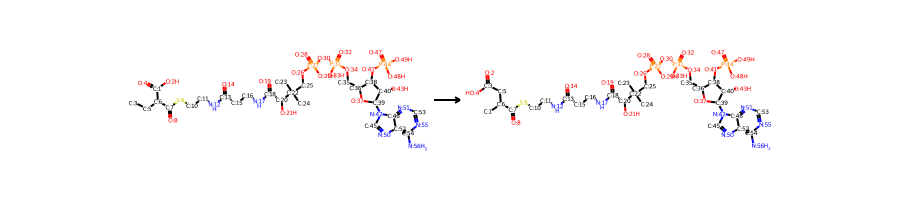

Mapping 2: 16573


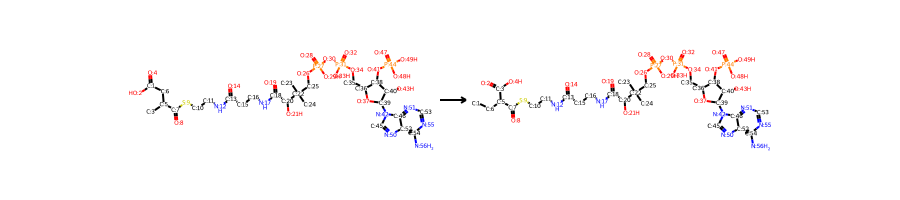

In [18]:
for i, row in enumerate(isom.iter_rows(named=True)):
    print(f"Mapping {i+1}: {row['rxn_id']}")
    display(
        SVG(
            draw_reaction(row['am_smarts'])
        )
    )

In [19]:
ni = pl.read_csv(
    "/home/stef/enz_rxn_data/artifacts/rules/ni_min_rules.tsv",
    separator="\t"
)

In [20]:
from ergochemics.mapping import extract_operator_patts

In [21]:
intra_dot = []
for row in ni.iter_rows(named=True):
    elts = extract_operator_patts(row['SMARTS'])
    for mol in elts[0]:
        if "." in mol:
            intra_dot.append(row)

In [22]:
len(intra_dot)

221

In [23]:
intra_dot

[{'Name': 'rule0028',
  'Reactants': 'Any',
  'SMARTS': '([#6:1].[#6:2]-[#6:3])>>([#6:2].[#6:1]-[#6:3])',
  'Products': 'Any',
  'Comments': 'A0A037YIF5;A0A067K3N5;A0A067ZIC8;A0A068Q609;A0A0A1H8D7;A0A0A1H8I4;A0A0A1HAT7;A0A0F6SCP6;A0A0F6VXD6;A0A0F6VXD9;A0A0F6VXE2;A0A0F6VXM2;A0A0F6YF18;A0A0H2UQY4;A0A0H2URG4;A0A140YIA2;A0A168GPL0;A0A168GPR3;A0A1D3TPC3;A0A1D3TXG7;A0A1T4LJY0;A0A223K4L6;A0LT86;A1A0H0;A1T974;A2EGX9;A2FT29;A2R3C7;A3C4S4;A3E7Z6;A3MUJ4;A3TM80;A4XGA6;A4XHV7;A4XJ56;A4YEG1;A5FA14;A5K8X6;A6UKD1;A6X7I5;A7LVG6;A8CEF6;A8DEZ8;A8RG82;A8YZE2;A9AYF3;A9LRT7;A9LS51;AE2015;AJH12524;AM180355;B0L964;B0M3E8;B1X789;B2ILS5;B2ZWT4;B2ZWT5;B3KMU8;B3WBA1;B3XZI5;B4FHU1;B5KJG2;B5KJG3;B5Z7L9;B6E5W6;B6VCW7;B7SLY1;B7XBM0;B8DZK4;B8DZQ9;B8E1T1;B8E1U6;B8LFE4;B8XP93;C0SSE7;C1FW08;C1JFF5;C1KKR1;C4LTW4;C5BUF0;C5MR76;C6K2K9;C6K2L0;C6VW66;C6XVU9;C6Y403;C7ACH5;C7AU21;C7G532;C8VAU8;CG9681;CYP153A11;CYP153A8;D0MF61;D1NPG0;D1TQG1;D2DK62;D2QDA5;D3JYW9;D5LNE5;D5MTT1;D7R810;D9ILD9;D9RZ53;D9SR73;D9TH31;D9TIY8;E0RU15;E3PRJ

In [24]:
mol = Chem.MolFromSmiles('CO')
patt = Chem.MolFromSmarts("[#6:1].[#8:2]")
mol.GetSubstructMatches(patt)

((0, 1),)

In [25]:
rxn = "C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)OP(=O)(O)O)O)O)O)O>>C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)OP(=O)(O)O"
rule = '([#8:1].[#8:2]-[#15:3])>>([#8:2].[#8:1]-[#15:3])'
res = operator_map_reaction(rxn, rule)
res

[08:43:15] Initializing MetalDisconnector
[08:43:15] Running MetalDisconnector
[08:43:15] Initializing Normalizer
[08:43:15] Running Normalizer
[08:43:15] Initializing MetalDisconnector
[08:43:15] Running MetalDisconnector
[08:43:15] Initializing Normalizer
[08:43:15] Running Normalizer


OperatorMapResult(did_map=True, aligned_smarts='O=P(O)(O)OC1OC(CO)C(O)C(O)C1O>>O=P(O)(O)OCC1OC(O)C(O)C(O)C1O', atom_mapped_smarts='[O:14]=[P:3]([OH:15])([OH:16])[O:1][CH:8]1[O:6][CH:5]([CH2:4][OH:2])[CH:7]([OH:9])[CH:10]([OH:12])[CH:11]1[OH:13]>>[O:14]=[P:3]([OH:15])([OH:16])[O:2][CH2:4][CH:5]1[O:6][CH:8]([OH:1])[CH:11]([OH:13])[CH:10]([OH:12])[CH:7]1[OH:9]', reaction_center=(((9, 4, 1),), ((1, 4, 9),)))

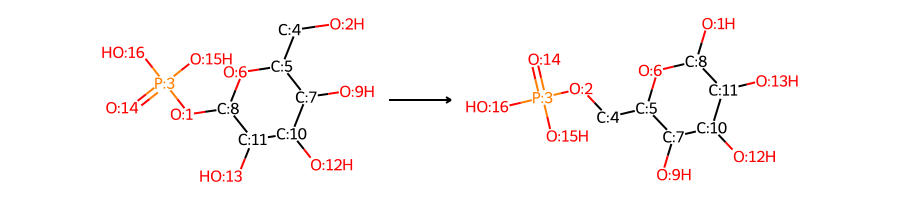

In [26]:
display(
    SVG(
        draw_reaction(res.atom_mapped_smarts)
    )
)